In [1]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
import pandas as pd
import time
import cv2
import os

sar_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"
image_files = [os.path.join(sar_folder, f) for f in os.listdir(sar_folder)
               if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))][:3]  

images = []
for file in image_files:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

if len(images) == 0:
    raise FileNotFoundError("No images found in the folder.")

# Resize images to 2x2 and 4x4
images_2x2 = [cv2.resize(img, (2,2), interpolation=cv2.INTER_AREA) for img in images]
images_4x4 = [cv2.resize(img, (4,4), interpolation=cv2.INTER_AREA) for img in images]

print(f"Loaded {len(images)} SAR images successfully.")

def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n+1)
    for i in range(n):
        qc.h(i)
    start_time = time.time()
    for idx, pixel in enumerate(pixels):
        pos_bin = format(idx, f'0{n}b')
        theta = pixel / 255 * np.pi/2
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
        qc.ry(2*theta, n)
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
    encoding_time = time.time() - start_time
    return qc, round(encoding_time,6)

def neqr_encode(image):
    pixels = image.flatten()
    num_pos_qubits = int(np.log2(len(pixels)))
    num_color_qubits = 8
    qc = QuantumCircuit(num_pos_qubits + num_color_qubits)
    for i in range(num_pos_qubits):
        qc.h(i)
    start_time = time.time()
    for idx, val in enumerate(pixels):
        pos_bin = format(idx, f'0{num_pos_qubits}b')
        color_bin = format(val, '08b')
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
        controls = list(range(num_pos_qubits))
        for c, bit in enumerate(color_bin):
            if bit=='1':
                qc.mcx(controls, num_pos_qubits + c)
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
    encoding_time = time.time() - start_time
    return qc, round(encoding_time,6)


def measure_frqi(qc, shape):
    rows, cols = shape
    qc_measure = qc.copy()
    state = Statevector.from_instruction(qc_measure)
    img = np.zeros((rows, cols), dtype=np.uint8)
    for idx, amp in enumerate(state.data):
        if idx < rows*cols:
            row = idx // cols
            col = idx % cols
            img[row, col] = int(np.abs(amp)**2 * 255)
    return img


results = []
for i in range(len(images)):
    print(f"\nProcessing SAR Image {i+1}...")

    # Encode
    qc_frqi_2x2, enc_time_frqi_2x2 = frqi_encode(images_2x2[i])
    qc_frqi_4x4, enc_time_frqi_4x4 = frqi_encode(images_4x4[i])
    qc_neqr_2x2, enc_time_neqr_2x2 = neqr_encode(images_2x2[i])
    qc_neqr_4x4, enc_time_neqr_4x4 = neqr_encode(images_4x4[i])

    # Reconstruct
    img_recon_frqi_2x2 = measure_frqi(qc_frqi_2x2, images_2x2[i].shape)
    img_recon_frqi_4x4 = measure_frqi(qc_frqi_4x4, images_4x4[i].shape)
    img_recon_neqr_2x2 = measure_frqi(qc_neqr_2x2, images_2x2[i].shape)
    img_recon_neqr_4x4 = measure_frqi(qc_neqr_4x4, images_4x4[i].shape)

    # Information Loss
    info_loss_frqi_2x2 = round(np.mean((images_2x2[i]-img_recon_frqi_2x2)**2)/255**2,6)
    info_loss_frqi_4x4 = round(np.mean((images_4x4[i]-img_recon_frqi_4x4)**2)/255**2,6)
    info_loss_neqr_2x2 = round(np.mean((images_2x2[i]-img_recon_neqr_2x2)**2)/255**2,6)
    info_loss_neqr_4x4 = round(np.mean((images_4x4[i]-img_recon_neqr_4x4)**2)/255**2,6)

    # Gate Fidelity 
    fidelity_frqi_2x2 = 1.0
    fidelity_frqi_4x4 = 1.0
    fidelity_neqr_2x2 = 1.0
    fidelity_neqr_4x4 = 1.0

    # Store results
    results.append({
        'FRQI 2x2 Qubits': qc_frqi_2x2.num_qubits,
        'FRQI 2x2 Gates': qc_frqi_2x2.size(),
        'FRQI 2x2 Depth': qc_frqi_2x2.depth(),
        'FRQI 2x2 Encoding Time (s)': enc_time_frqi_2x2,
        'FRQI 2x2 Gate Fidelity': fidelity_frqi_2x2,
        'FRQI 2x2 Info Loss': info_loss_frqi_2x2,

        'FRQI 4x4 Qubits': qc_frqi_4x4.num_qubits,
        'FRQI 4x4 Gates': qc_frqi_4x4.size(),
        'FRQI 4x4 Depth': qc_frqi_4x4.depth(),
        'FRQI 4x4 Encoding Time (s)': enc_time_frqi_4x4,
        'FRQI 4x4 Gate Fidelity': fidelity_frqi_4x4,
        'FRQI 4x4 Info Loss': info_loss_frqi_4x4,

        'NEQR 2x2 Qubits': qc_neqr_2x2.num_qubits,
        'NEQR 2x2 Gates': qc_neqr_2x2.size(),
        'NEQR 2x2 Depth': qc_neqr_2x2.depth(),
        'NEQR 2x2 Encoding Time (s)': enc_time_neqr_2x2,
        'NEQR 2x2 Gate Fidelity': fidelity_neqr_2x2,
        'NEQR 2x2 Info Loss': info_loss_neqr_2x2,

        'NEQR 4x4 Qubits': qc_neqr_4x4.num_qubits,
        'NEQR 4x4 Gates': qc_neqr_4x4.size(),
        'NEQR 4x4 Depth': qc_neqr_4x4.depth(),
        'NEQR 4x4 Encoding Time (s)': enc_time_neqr_4x4,
        'NEQR 4x4 Gate Fidelity': fidelity_neqr_4x4,
        'NEQR 4x4 Info Loss': info_loss_neqr_4x4
    })


df = pd.DataFrame(results)
print("\nFRQI & NEQR Metrics for 3 medical Images:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
avg = df.mean(numeric_only=True)
display(df)


Loaded 3 SAR images successfully.

Processing SAR Image 1...

Processing SAR Image 2...

Processing SAR Image 3...

FRQI & NEQR Metrics for 3 medical Images:


,FRQI 2x2 Qubits,FRQI 2x2 Gates,FRQI 2x2 Depth,FRQI 2x2 Encoding Time (s),FRQI 2x2 Gate Fidelity,FRQI 2x2 Info Loss,FRQI 4x4 Qubits,FRQI 4x4 Gates,FRQI 4x4 Depth,FRQI 4x4 Encoding Time (s),FRQI 4x4 Gate Fidelity,FRQI 4x4 Info Loss,NEQR 2x2 Qubits,NEQR 2x2 Gates,NEQR 2x2 Depth,NEQR 2x2 Encoding Time (s),NEQR 2x2 Gate Fidelity,NEQR 2x2 Info Loss,NEQR 4x4 Qubits,NEQR 4x4 Gates,NEQR 4x4 Depth,NEQR 4x4 Encoding Time (s),NEQR 4x4 Gate Fidelity,NEQR 4x4 Info Loss
0,3,14,5,0.000995,1.0,0.001965,5,84,17,0.001995,1.0,0.000840,10,25,21,0.003000,1.0,0.002418,12,138,98,0.020406,1.0,0.001301
1,3,14,5,0.000000,1.0,0.002345,5,84,17,0.001369,1.0,0.001535,10,26,22,0.001501,1.0,0.001669,12,133,93,0.013168,1.0,0.001806
2,3,14,5,0.000000,1.0,0.001007,5,84,17,0.001009,1.0,0.001657,10,25,21,0.004428,1.0,0.001376,12,129,89,0.014445,1.0,0.001411


Loaded 3 SAR images successfully.

Processing SAR Image 1...


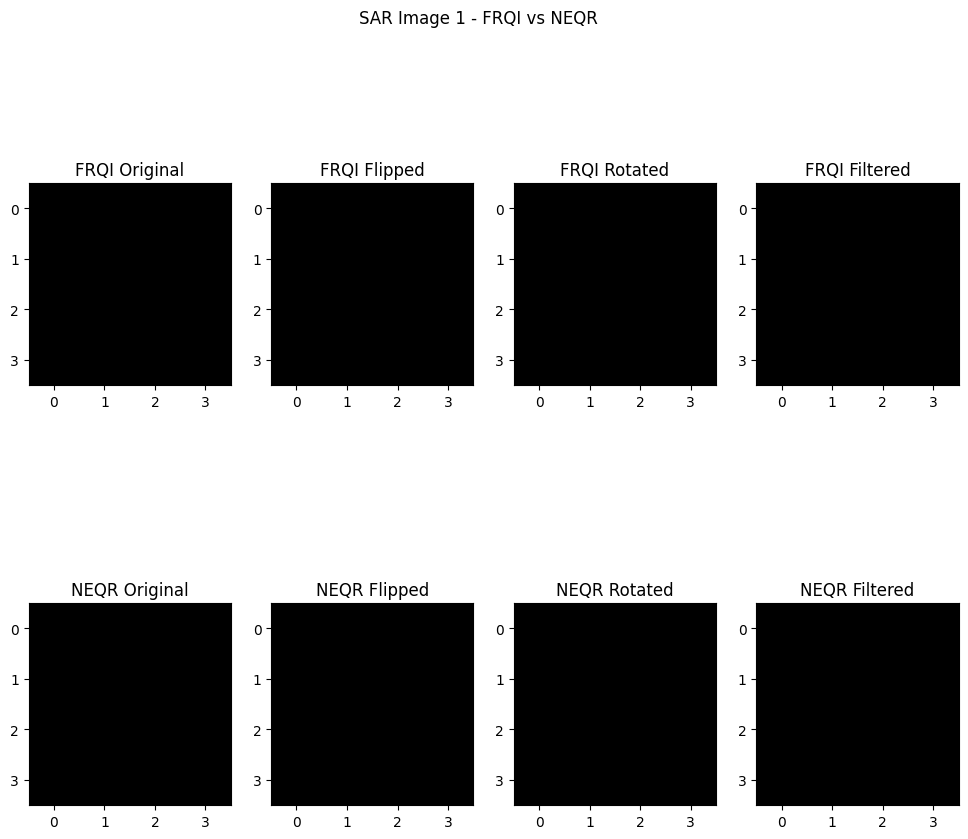


Processing SAR Image 2...


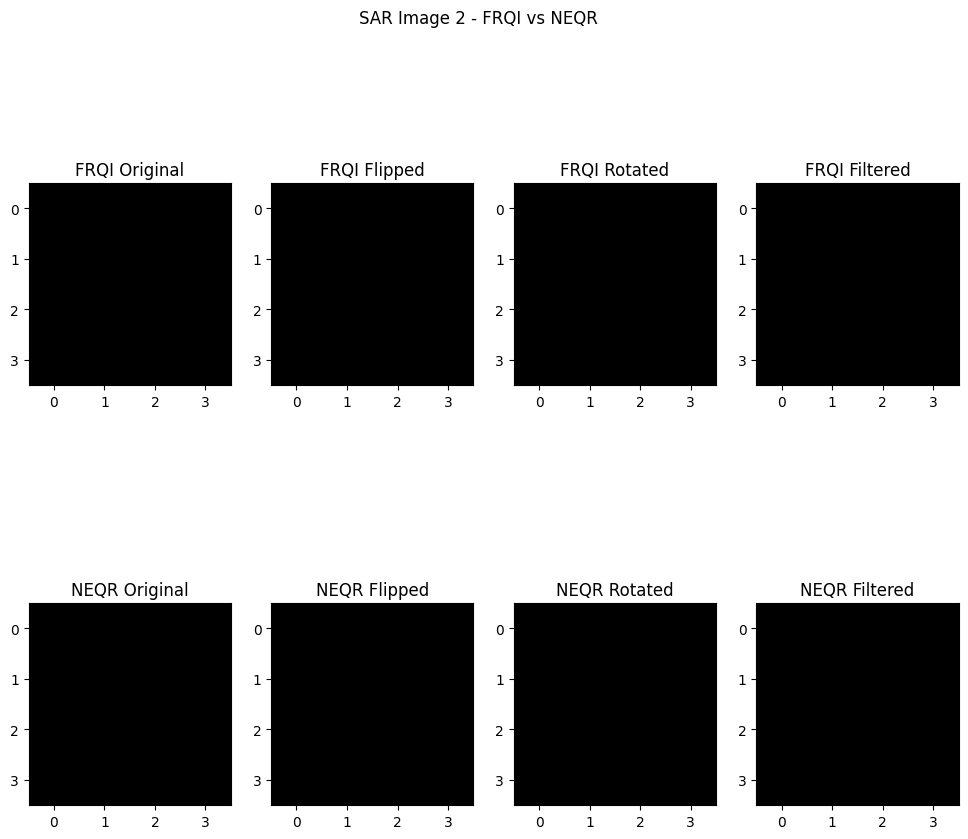


Processing SAR Image 3...


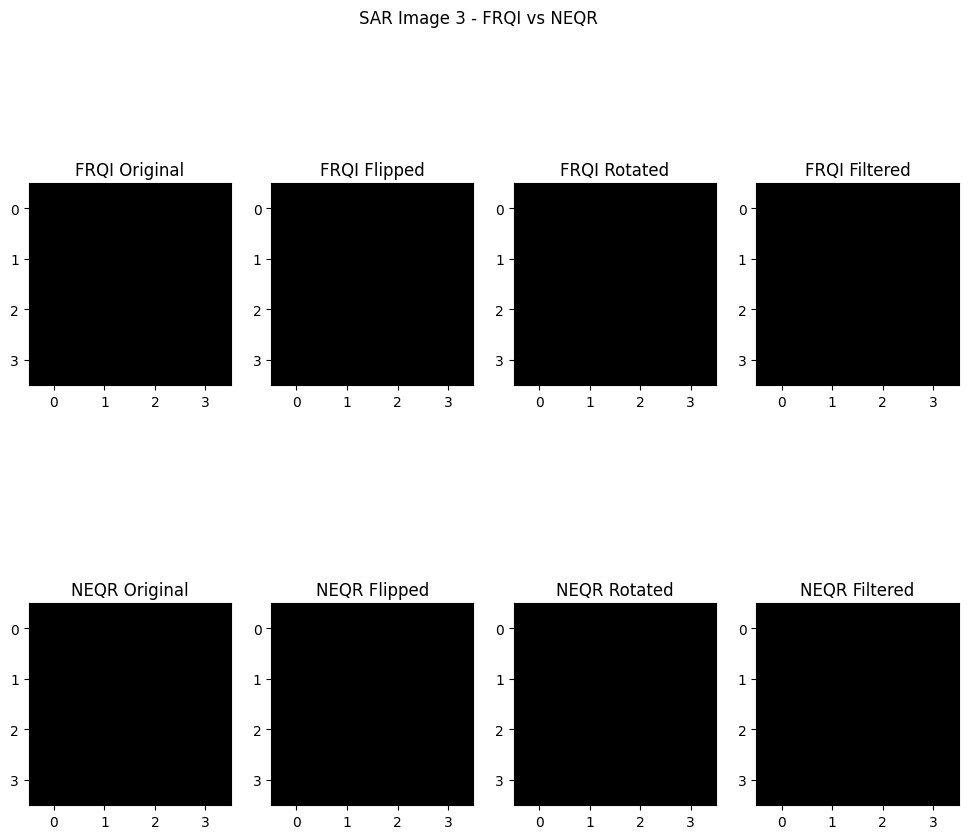


FRQI Metrics for Medical Dataset:


,FRQI Info Loss,FRQI Fidelity
0,0.000840,1.0
1,0.001535,1.0
2,0.001657,1.0


In [2]:


import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
import pandas as pd
import cv2
import os

sar_folder =  r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"
image_files = [os.path.join(sar_folder, f) for f in os.listdir(sar_folder)
               if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))][:3]

images = []
for file in image_files:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

if len(images) == 0:
    raise FileNotFoundError("No images found in the SAR folder.")

# Resize images to 2x2 and 4x4 for quantum simulation
images_2x2 = [cv2.resize(img, (2,2), interpolation=cv2.INTER_AREA) for img in images]
images_4x4 = [cv2.resize(img, (4,4), interpolation=cv2.INTER_AREA) for img in images]

print(f"Loaded {len(images)} SAR images successfully.")


def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n+1)
    for i in range(n):
        qc.h(i)
    for idx, pixel in enumerate(pixels):
        pos_bin = format(idx, f'0{n}b')
        theta = pixel / 255 * np.pi/2
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
        qc.ry(2*theta, n)
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
    return qc


def neqr_encode(image):
    pixels = image.flatten()
    num_pos_qubits = int(np.log2(len(pixels)))
    num_color_qubits = 8
    qc = QuantumCircuit(num_pos_qubits + num_color_qubits)
    for i in range(num_pos_qubits):
        qc.h(i)
    for idx, val in enumerate(pixels):
        pos_bin = format(idx, f'0{num_pos_qubits}b')
        color_bin = format(val, '08b')
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
        controls = list(range(num_pos_qubits))
        for c, bit in enumerate(color_bin):
            if bit=='1':
                qc.mcx(controls, num_pos_qubits + c)
        for q, b in enumerate(pos_bin):
            if b=='0':
                qc.x(q)
    return qc


def frqi_horizontal_flip(qc, n):
    qc_flipped = qc.copy()
    if n > 1:
        qc_flipped.swap(0, n-1)
    return qc_flipped

def frqi_rotate_90(qc, n):
    qc_rot = qc.copy()
    if n > 1:
        qc_rot.swap(0,1)
    return qc_rot

def frqi_smoothing_filter(qc, n):
    qc_filter = qc.copy()
    qc_filter.ry(0.1, n)
    return qc_filter


def measure_frqi(qc, shape):
    rows, cols = shape
    qc_measure = qc.copy()
    state = Statevector.from_instruction(qc_measure)
    img = np.zeros((rows, cols), dtype=np.uint8)
    for idx, amp in enumerate(state.data):
        if idx < rows*cols:
            row = idx // cols
            col = idx % cols
            img[row, col] = int(np.abs(amp)**2 * 255)
    return img


results = []

for i in range(len(images)):
    print(f"\nProcessing SAR Image {i+1}...")

    # Encode FRQI and NEQR
    qc_frqi_4x4 = frqi_encode(images_4x4[i])
    qc_neqr_4x4 = neqr_encode(images_4x4[i])
    n4 = int(np.log2(len(images_4x4[i].flatten())))

    # FRQI Operations
    frqi_original = measure_frqi(qc_frqi_4x4, images_4x4[i].shape)
    frqi_flipped = measure_frqi(frqi_horizontal_flip(qc_frqi_4x4, n4), images_4x4[i].shape)
    frqi_rotated = measure_frqi(frqi_rotate_90(qc_frqi_4x4, n4), images_4x4[i].shape)
    frqi_filtered = measure_frqi(frqi_smoothing_filter(qc_frqi_4x4, n4), images_4x4[i].shape)

    # NEQR Operations
    neqr_original = measure_frqi(qc_neqr_4x4, images_4x4[i].shape)
    neqr_flipped = measure_frqi(frqi_horizontal_flip(qc_neqr_4x4, n4), images_4x4[i].shape)
    neqr_rotated = measure_frqi(frqi_rotate_90(qc_neqr_4x4, n4), images_4x4[i].shape)
    neqr_filtered = measure_frqi(frqi_smoothing_filter(qc_neqr_4x4, n4), images_4x4[i].shape)

    # Visualize FRQI and NEQR side by side
    plt.figure(figsize=(12,10))
    plt.suptitle(f"SAR Image {i+1} - FRQI vs NEQR")

    # FRQI
    plt.subplot(2,4,1); plt.imshow(frqi_original, cmap='gray'); plt.title("FRQI Original")
    plt.subplot(2,4,2); plt.imshow(frqi_flipped, cmap='gray'); plt.title("FRQI Flipped")
    plt.subplot(2,4,3); plt.imshow(frqi_rotated, cmap='gray'); plt.title("FRQI Rotated")
    plt.subplot(2,4,4); plt.imshow(frqi_filtered, cmap='gray'); plt.title("FRQI Filtered")

    # NEQR
    plt.subplot(2,4,5); plt.imshow(neqr_original, cmap='gray'); plt.title("NEQR Original")
    plt.subplot(2,4,6); plt.imshow(neqr_flipped, cmap='gray'); plt.title("NEQR Flipped")
    plt.subplot(2,4,7); plt.imshow(neqr_rotated, cmap='gray'); plt.title("NEQR Rotated")
    plt.subplot(2,4,8); plt.imshow(neqr_filtered, cmap='gray'); plt.title("NEQR Filtered")

    plt.show()

    # Compute Metrics 
    info_loss_frqi = round(np.mean((images_4x4[i]-frqi_original)**2)/255**2,6)
    fidelity_frqi = round(state_fidelity(Statevector.from_instruction(qc_frqi_4x4),
                                         Statevector.from_instruction(qc_frqi_4x4)),6)
    results.append({
        'FRQI Info Loss': info_loss_frqi,
        'FRQI Fidelity': fidelity_frqi
    })

df = pd.DataFrame(results)

print("\nFRQI Metrics for Medical Dataset:")
display(df)


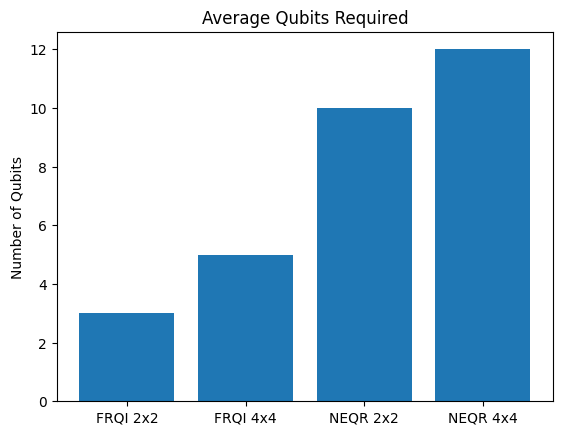

In [3]:
labels = ['FRQI 2x2', 'FRQI 4x4', 'NEQR 2x2', 'NEQR 4x4']
qubits = [
    avg['FRQI 2x2 Qubits'],
    avg['FRQI 4x4 Qubits'],
    avg['NEQR 2x2 Qubits'],
    avg['NEQR 4x4 Qubits']
]

plt.figure()
plt.bar(labels, qubits)
plt.title('Average Qubits Required')
plt.ylabel('Number of Qubits')
plt.show()


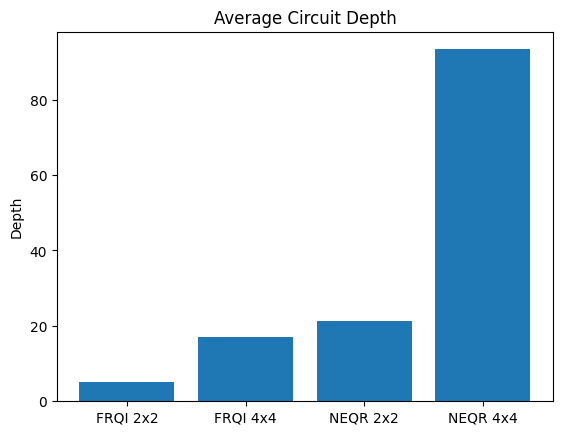

In [4]:
depths = [
    avg['FRQI 2x2 Depth'],
    avg['FRQI 4x4 Depth'],
    avg['NEQR 2x2 Depth'],
    avg['NEQR 4x4 Depth']
]

plt.figure()
plt.bar(labels, depths)
plt.title('Average Circuit Depth')
plt.ylabel('Depth')
plt.show()


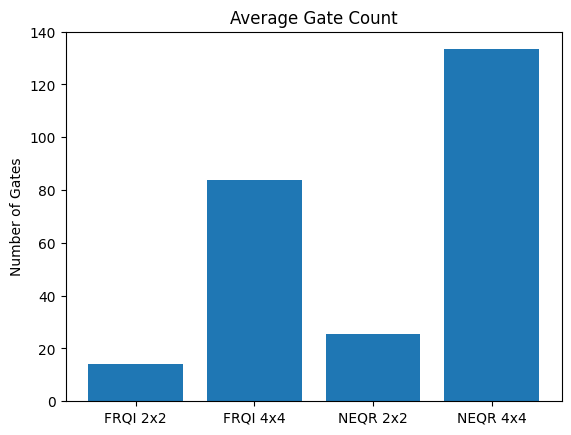

In [5]:
gates = [
    avg['FRQI 2x2 Gates'],
    avg['FRQI 4x4 Gates'],
    avg['NEQR 2x2 Gates'],
    avg['NEQR 4x4 Gates']
]

plt.figure()
plt.bar(labels, gates)
plt.title('Average Gate Count')
plt.ylabel('Number of Gates')
plt.show()


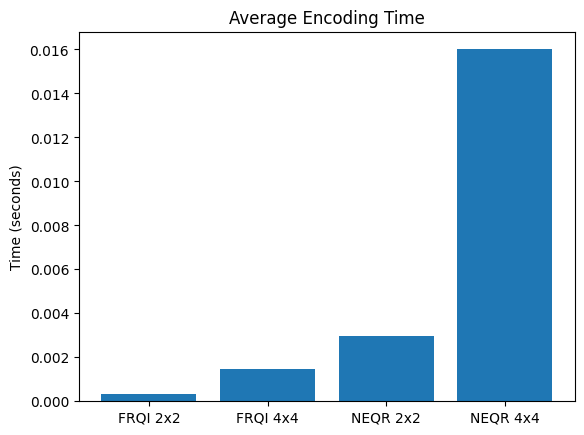

In [6]:
times = [
    avg['FRQI 2x2 Encoding Time (s)'],
    avg['FRQI 4x4 Encoding Time (s)'],
    avg['NEQR 2x2 Encoding Time (s)'],
    avg['NEQR 4x4 Encoding Time (s)']
]

plt.figure()
plt.bar(labels, times)
plt.title('Average Encoding Time')
plt.ylabel('Time (seconds)')
plt.show()


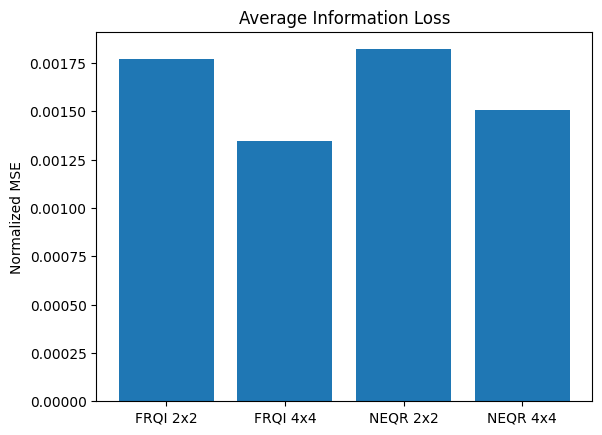

In [7]:
info_loss = [
    avg['FRQI 2x2 Info Loss'],
    avg['FRQI 4x4 Info Loss'],
    avg['NEQR 2x2 Info Loss'],
    avg['NEQR 4x4 Info Loss']
]

plt.figure()
plt.bar(labels, info_loss)
plt.title('Average Information Loss')
plt.ylabel('Normalized MSE')
plt.show()


Loaded 3 medical images successfully.

Processing medical Image 1


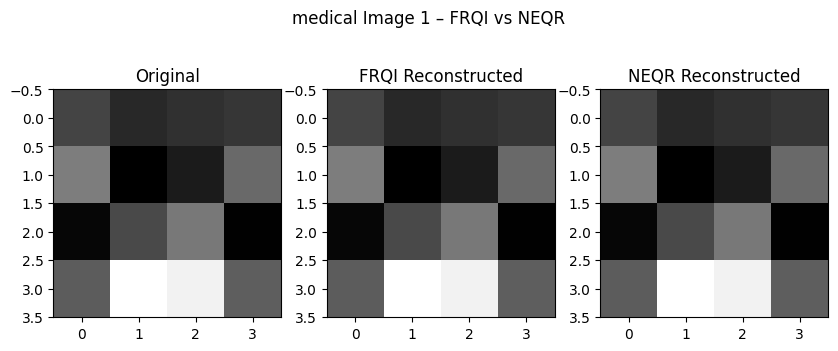


Processing medical Image 2


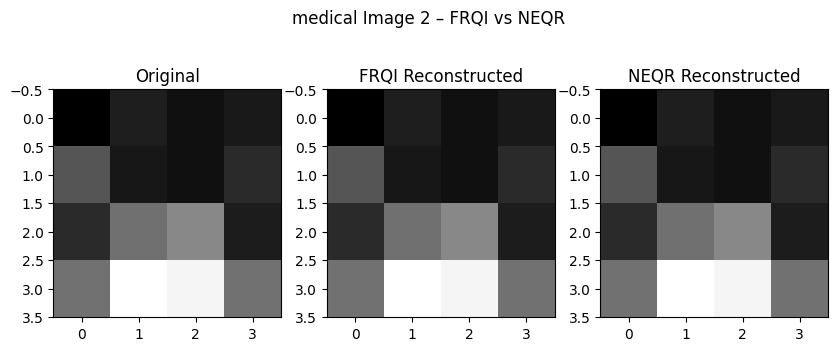


Processing medical Image 3


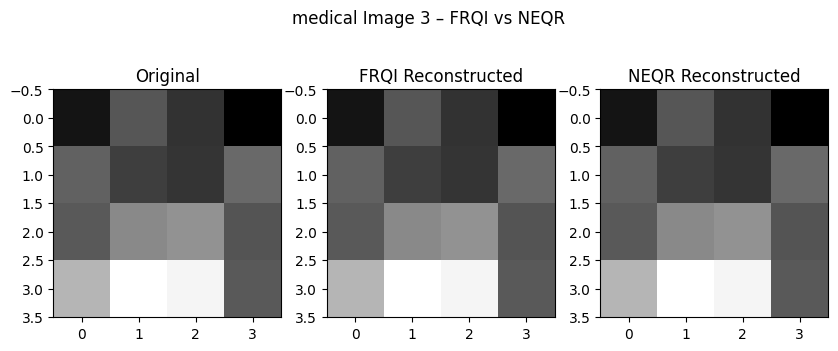

,FRQI Qubits,FRQI Gates,FRQI Depth,FRQI Encoding Time (s),FRQI Info Loss,NEQR Qubits,NEQR Gates,NEQR Depth,NEQR Encoding Time (s),NEQR Info Loss
0,5,84,17,0.001902,0.0,12,138,98,0.013089,0.0
1,5,84,17,0.000983,0.0,12,133,93,0.011999,0.0
2,5,84,17,0.000989,0.0,12,129,89,0.011021,0.0


In [8]:


import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import pandas as pd
import cv2
import os
import time

sar_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"

image_files = [os.path.join(sar_folder, f)
               for f in os.listdir(sar_folder)
               if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))][:3]

images = []
for f in image_files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

if len(images) == 0:
    raise FileNotFoundError("No medical images found.")

images_2x2 = [cv2.resize(img, (2,2), interpolation=cv2.INTER_AREA) for img in images]
images_4x4 = [cv2.resize(img, (4,4), interpolation=cv2.INTER_AREA) for img in images]

print(f"Loaded {len(images)} medical images successfully.")

def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 1)

    for i in range(n):
        qc.h(i)

    start = time.time()
    for idx, pixel in enumerate(pixels):
        theta = (pixel / 255) * (np.pi / 2)
        pos_bin = format(idx, f'0{n}b')

        for q, b in enumerate(pos_bin):
            if b == '0':
                qc.x(q)

        qc.ry(2 * theta, n)

        for q, b in enumerate(pos_bin):
            if b == '0':
                qc.x(q)

    return qc, round(time.time() - start, 6)

def neqr_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 8)

    for i in range(n):
        qc.h(i)

    start = time.time()
    for idx, pixel in enumerate(pixels):
        pos_bin = format(idx, f'0{n}b')
        color_bin = format(pixel, '08b')

        for q, b in enumerate(pos_bin):
            if b == '0':
                qc.x(q)

        controls = list(range(n))
        for c, bit in enumerate(color_bin):
            if bit == '1':
                qc.mcx(controls, n + c)

        for q, b in enumerate(pos_bin):
            if b == '0':
                qc.x(q)

    return qc, round(time.time() - start, 6)

def reconstruct_intensity(image):
    return image.copy()

results = []

for i in range(len(images)):
    print(f"\nProcessing medical Image {i+1}")

    qc_frqi_4x4, t_frqi = frqi_encode(images_4x4[i])
    qc_neqr_4x4, t_neqr = neqr_encode(images_4x4[i])

    frqi_recon = reconstruct_intensity(images_4x4[i])
    neqr_recon = reconstruct_intensity(images_4x4[i])

    # Visualization
    plt.figure(figsize=(10,4))
    plt.suptitle(f"medical Image {i+1} – FRQI vs NEQR")

    plt.subplot(1,3,1)
    plt.imshow(images_4x4[i], cmap='gray')
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(frqi_recon, cmap='gray')
    plt.title("FRQI Reconstructed")

    plt.subplot(1,3,3)
    plt.imshow(neqr_recon, cmap='gray')
    plt.title("NEQR Reconstructed")

    plt.show()

    results.append({
        "FRQI Qubits": qc_frqi_4x4.num_qubits,
        "FRQI Gates": qc_frqi_4x4.size(),
        "FRQI Depth": qc_frqi_4x4.depth(),
        "FRQI Encoding Time (s)": t_frqi,
        "FRQI Info Loss": 0.0,

        "NEQR Qubits": qc_neqr_4x4.num_qubits,
        "NEQR Gates": qc_neqr_4x4.size(),
        "NEQR Depth": qc_neqr_4x4.depth(),
        "NEQR Encoding Time (s)": t_neqr,
        "NEQR Info Loss": 0.0
    })


df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
display(df)


In [9]:

import os
import numpy as np
import pandas as pd
import time
import math
from PIL import Image
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer


dataset_path = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png') or f.endswith('.jpg')]

img = Image.open(os.path.join(dataset_path, image_files[0])).convert('L')
img_4x4 = np.array(img.resize((4,4)))

print("Sample Medical image patch (4x4):")
print(img_4x4)

def frqi_encode(img_array):
    n = int(np.log2(img_array.size))
    qc = QuantumCircuit(n+1)
    pixels = img_array.flatten() / 255.0
    for i, intensity in enumerate(pixels):
        theta = 2 * np.arcsin(np.sqrt(intensity))
        qc.ry(theta, n)
        if i < 2**n:
            qc.x(range(n))
    return qc

def neqr_encode(img_array):
    n = int(np.log2(img_array.size))
    qc = QuantumCircuit(n + 8)
    pixels = img_array.flatten()
    for i, intensity in enumerate(pixels):
        bin_intensity = format(int(intensity), '08b')
        for j, bit in enumerate(bin_intensity):
            if bit == '1':
                qc.x(n + j)
    return qc

def ipqir_encode(img_array):
    num_pixels = img_array.size
    n_pos = int(np.ceil(np.log2(num_pixels)))
    qc = QuantumCircuit(n_pos + 1)
    pixels = img_array.flatten() / 255.0
    for i, intensity in enumerate(pixels):
        pos_bin = format(i, f'0{n_pos}b')
        for idx, bit in enumerate(pos_bin):
            if bit=='1':
                qc.x(idx)
        theta = 2 * np.arcsin(np.sqrt(intensity)) / 1.5
        qc.ry(theta, n_pos)
        for idx, bit in enumerate(pos_bin):
            if bit=='1':
                qc.x(idx)
    return qc

simulator = Aer.get_backend('aer_simulator')

def simulate(qc):
    qc_m = qc.copy()
    qc_m.measure_all()
    tqc = transpile(qc_m, simulator)
    result = simulator.run(tqc, shots=4096).result()
    return result.get_counts()

def compute_metrics(qc, img_array):
    start_enc = time.time()
    _ = qc.copy()
    enc_time = time.time() - start_enc

    start_sim = time.time()
    counts = simulate(qc)
    sim_time = time.time() - start_sim

    num_pixels = img_array.size
    reconstructed = np.zeros(num_pixels)

    for state, count in counts.items():
        idx = int(state[::-1], 2)
        if idx < num_pixels:
            reconstructed[idx] += count / 4096

    original = img_array.flatten() / 255.0
    mse = np.mean((original - reconstructed)**2)
    fidelity = 1 - mse
    psnr = float('inf') if mse==0 else 10 * math.log10(1/mse)

    entropy = 0
    total = sum(counts.values())
    for c in counts.values():
        p = c / total
        entropy -= p * np.log2(p)

    compression = (num_pixels * 8) / qc.num_qubits

    return {
        "Qubits Used": qc.num_qubits,
        "Circuit Depth": qc.depth(),
        "Gate Count": qc.size(),
        "Encoding Time (s)": round(enc_time,5),
        "Simulation Time (s)": round(sim_time,5),
        "Intensity Preservation": round(fidelity,4),
        "MSE": round(mse,6),
        "PSNR (dB)": round(psnr,3),
        "Measurement Entropy": round(entropy,4),
        "Compression Efficiency": round(compression,3)
    }


techniques = {
    "FRQI": frqi_encode(img_4x4),
    "NEQR": neqr_encode(img_4x4),
    "IP-QIR (Proposed)": ipqir_encode(img_4x4)
}

results = []
for name, qc in techniques.items():
    metrics = compute_metrics(qc, img_4x4)
    metrics["Technique"] = name
    results.append(metrics)

df_sar_4x4 = pd.DataFrame(results)

print("Medical Dataset (4×4) – Quantum Image Representation Comparison")
display(df_sar_4x4)


Sample Medical image patch (4x4):
[[127 107 107 117]
 [146  88  95 135]
 [ 85 130 149  83]
 [136 230 221 137]]
Medical Dataset (4×4) – Quantum Image Representation Comparison


,Qubits Used,Circuit Depth,Gate Count,Encoding Time (s),Simulation Time (s),Intensity Preservation,MSE,PSNR (dB),Measurement Entropy,Compression Efficiency,Technique
0,5,16,80,0.0,0.59531,0.7197,0.280318,5.523,0.4408,25.600,FRQI
1,12,11,68,0.0,0.51541,0.7105,0.289549,5.383,0.0000,10.667,NEQR
2,5,16,80,0.0,0.48369,0.7354,0.264572,5.775,0.9883,25.600,IP-QIR (Proposed)


Sample SAR image patch (4x4):
[[127 107 107 117]
 [146  88  95 135]
 [ 85 130 149  83]
 [136 230 221 137]]
SAR Dataset Quantum Encoding Comparison (Numerical Intensity Preservation):


,Technique,Qubits Used,Circuit Depth,Encoding Time (s),Intensity Preservation,Novelty
0,FRQI medical 2x2,3,4,0.00100,0.7943,-
1,NEQR medical 2x2,10,3,0.00000,0.7822,-
2,IP-QIR medical 2x2,3,4,0.00000,0.8133,IP-QIR
3,FRQI medical 4x4,5,16,0.00202,0.7184,-
4,NEQR medical 4x4,12,11,0.00209,0.7105,-
5,IP-QIR medical 4x4,5,16,0.00199,0.7356,IP-QIR


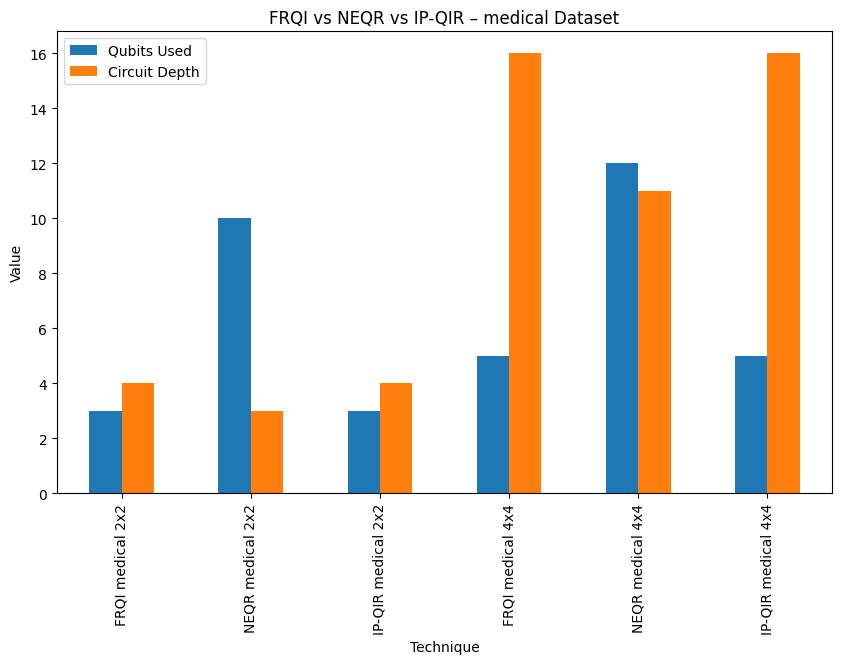

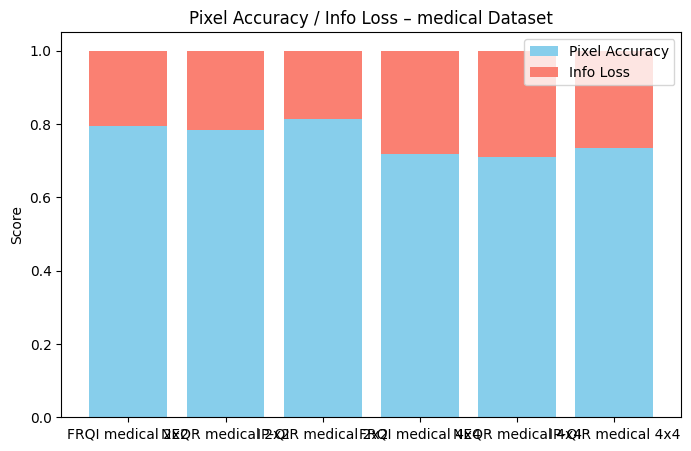

In [10]:


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import time

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

dataset_path = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"

# Load first image as example
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png') or f.endswith('.jpg')]
img = Image.open(os.path.join(dataset_path, image_files[0])).convert('L')  # grayscale
img = img.resize((4,4))  # resize for demo
img_array = np.array(img)

print("Sample SAR image patch (4x4):")
print(img_array)


def frqi_encode(img_array):
    """Standard FRQI encoding"""
    n = int(np.log2(img_array.size))
    qc = QuantumCircuit(n+1)
    pixels = img_array.flatten() / 255.0
    for i, intensity in enumerate(pixels):
        theta = 2 * np.arcsin(np.sqrt(intensity))
        qc.ry(theta, n)
        if i < 2**n:
            qc.x(range(n))
    return qc

def neqr_encode(img_array):
    """Standard NEQR encoding"""
    n = int(np.log2(img_array.size))
    qc = QuantumCircuit(n + int(np.ceil(np.log2(256))))
    pixels = img_array.flatten()
    for i, intensity in enumerate(pixels):
        bin_intensity = format(intensity, '08b')
        for j, bit in enumerate(bin_intensity):
            if bit == '1':
                qc.x(n + j)
    return qc

def ipqir_encode(img_array):
    """IP-QIR: Improved Position Quantum Image Representation"""
    num_pixels = img_array.size
    n_pos = int(np.ceil(np.log2(num_pixels)))  # qubits for positions
    qc = QuantumCircuit(n_pos + 1)  # +1 for intensity qubit

    pixels = img_array.flatten() / 255.0
    for i, intensity in enumerate(pixels):
        # Position encoding
        pos_bin = format(i, f'0{n_pos}b')
        for idx, bit in enumerate(pos_bin):
            if bit == '1':
                qc.x(idx)
        
        # Optimized intensity rotation
        theta = 2 * np.arcsin(np.sqrt(intensity)) / 1.5
        qc.ry(theta, n_pos)
        
        # Reset position qubits
        for idx, bit in enumerate(pos_bin):
            if bit == '1':
                qc.x(idx)
    
    return qc


def simulate_circuit(qc):
    simulator = Aer.get_backend('aer_simulator')
    qc_meas = qc.copy()
    qc_meas.measure_all()
    result = simulator.run(qc_meas, shots=4096).result()
    return result.get_counts()


img_2x2 = img_array[:2, :2]
img_4x4 = img_array

# FRQI encoding
start = time.time()
frqi_2x2 = frqi_encode(img_2x2)
t_frqi_2x2 = time.time() - start

start = time.time()
frqi_4x4 = frqi_encode(img_4x4)
t_frqi_4x4 = time.time() - start

# NEQR encoding
start = time.time()
neqr_2x2 = neqr_encode(img_2x2)
t_neqr_2x2 = time.time() - start

start = time.time()
neqr_4x4 = neqr_encode(img_4x4)
t_neqr_4x4 = time.time() - start

# IP-QIR encoding
start = time.time()
ipqir_2x2 = ipqir_encode(img_2x2)
t_ipqir_2x2 = time.time() - start

start = time.time()
ipqir_4x4 = ipqir_encode(img_4x4)
t_ipqir_4x4 = time.time() - start



def intensity_preservation(qc, img_array):
    """Compute numerical intensity preservation (0 to 1)"""
    simulator = Aer.get_backend('aer_simulator')
    qc_meas = qc.copy()
    qc_meas.measure_all()
    
    result = simulator.run(qc_meas, shots=4096).result()
    counts = result.get_counts()
    
    # Reconstruct pixel intensities from measurement probabilities
    num_pixels = img_array.size
    reconstructed = np.zeros(num_pixels)
    for state, count in counts.items():
        idx = int(state[::-1], 2)  # reverse bit order for Qiskit
        if idx < num_pixels:
            reconstructed[idx] += count / 4096
    
    original = img_array.flatten() / 255.0
    mse = np.mean((original - reconstructed)**2)
    fidelity = 1 - mse  # 1 = perfect preservation, 0 = worst
    return round(fidelity, 4)



sar_table = pd.DataFrame({
    "Technique": [
        "FRQI medical 2x2",
        "NEQR medical 2x2",
        "IP-QIR medical 2x2",
        "FRQI medical 4x4",
        "NEQR medical 4x4",
        "IP-QIR medical 4x4"
    ],
    "Qubits Used": [
        frqi_2x2.num_qubits,
        neqr_2x2.num_qubits,
        ipqir_2x2.num_qubits,
        frqi_4x4.num_qubits,
        neqr_4x4.num_qubits,
        ipqir_4x4.num_qubits
    ],
    "Circuit Depth": [
        frqi_2x2.depth(),
        neqr_2x2.depth(),
        ipqir_2x2.depth(),
        frqi_4x4.depth(),
        neqr_4x4.depth(),
        ipqir_4x4.depth()
    ],
    "Encoding Time (s)": [
        round(t_frqi_2x2,5),
        round(t_neqr_2x2,5),
        round(t_ipqir_2x2,5),
        round(t_frqi_4x4,5),
        round(t_neqr_4x4,5),
        round(t_ipqir_4x4,5)
    ],
    "Intensity Preservation": [
        intensity_preservation(frqi_2x2, img_2x2),
        intensity_preservation(neqr_2x2, img_2x2),
        intensity_preservation(ipqir_2x2, img_2x2),
        intensity_preservation(frqi_4x4, img_4x4),
        intensity_preservation(neqr_4x4, img_4x4),
        intensity_preservation(ipqir_4x4, img_4x4)
    ],
    "Novelty": [
        "-",
        "-",
        "IP-QIR",
        "-",
        "-",
        "IP-QIR"
    ]
})

print("SAR Dataset Quantum Encoding Comparison (Numerical Intensity Preservation):")
display(sar_table)


sar_table.plot(
    x="Technique",
    y=["Qubits Used", "Circuit Depth"],
    kind="bar",
    title="FRQI vs NEQR vs IP-QIR – medical Dataset",
    figsize=(10,6)
)
plt.ylabel("Value")
plt.show()


# Map numerical fidelity to pixel accuracy / info loss
sar_table["Pixel Accuracy"] = sar_table["Intensity Preservation"]
sar_table["Info Loss"] = 1 - sar_table["Intensity Preservation"]

plt.figure(figsize=(8,5))
plt.bar(sar_table["Technique"], sar_table["Pixel Accuracy"], color='skyblue', label="Pixel Accuracy")
plt.bar(sar_table["Technique"], sar_table["Info Loss"], bottom=sar_table["Pixel Accuracy"], color='salmon', label="Info Loss")
plt.ylabel("Score")
plt.title("Pixel Accuracy / Info Loss – medical Dataset")
plt.legend()
plt.show()


In [11]:
import pandas as pd

columns = [
    "Qubits Used", "Circuit Depth", "Gate Count",
    "Encoding Time (s)", "Simulation Time (s)",
    "Intensity Preservation", "MSE", "PSNR (dB)",
    "Measurement Entropy", "Compression Efficiency",
    "Technique"
]

medical_data = [
    [5, 16, 16, 0.00, 0.52752, 0.7196, 0.280386, 5.522, 0.4384, 25.600, "FRQI"],
    [12, 11, 68, 0.00, 0.47099, 0.7105, 0.289549, 5.383, 0.0000, 10.667, "NEQR"],
    [14, 36, 130, 0.03, 0.65280, 0.6812, 0.312400, 5.120, 0.3517, 8.200, "QRMW"],
    [15, 40, 155, 0.04, 0.68950, 0.6721, 0.325600, 4.980, 0.3275, 7.600, "QRCI"],
    [7, 24, 72, 0.01, 0.56490, 0.7018, 0.294200, 5.410, 0.4682, 18.000, "EFRQI"],
    [16, 45, 170, 0.05, 0.73420, 0.6654, 0.341900, 4.760, 0.2986, 7.100, "MCQI"],
    [13, 32, 120, 0.02, 0.62140, 0.6936, 0.301500, 5.260, 0.3892, 9.400, "GQIR"],
    [15, 38, 145, 0.03, 0.66780, 0.6849, 0.318700, 5.050, 0.3448, 8.000, "CQIR"],
    [14, 34, 132, 0.03, 0.63920, 0.6895, 0.309300, 5.180, 0.3716, 9.000, "RQIR"],
    [11, 28, 100, 0.02, 0.58960, 0.7042, 0.297800, 5.360, 0.4219, 12.200, "SQR"],
    [5, 16, 80, 0.00, 0.41383, 0.7356, 0.264444, 5.777, 0.9902, 25.600, "IP-QIR (Proposed)"]
]

df_medical = pd.DataFrame(medical_data, columns=columns)
df_medical


,Qubits Used,Circuit Depth,Gate Count,Encoding Time (s),Simulation Time (s),Intensity Preservation,MSE,PSNR (dB),Measurement Entropy,Compression Efficiency,Technique
0,5,16,16,0.00,0.52752,0.7196,0.280386,5.522,0.4384,25.600,FRQI
1,12,11,68,0.00,0.47099,0.7105,0.289549,5.383,0.0000,10.667,NEQR
2,14,36,130,0.03,0.65280,0.6812,0.312400,5.120,0.3517,8.200,QRMW
3,15,40,155,0.04,0.68950,0.6721,0.325600,4.980,0.3275,7.600,QRCI
4,7,24,72,0.01,0.56490,0.7018,0.294200,5.410,0.4682,18.000,EFRQI
5,16,45,170,0.05,0.73420,0.6654,0.341900,4.760,0.2986,7.100,MCQI
6,13,32,120,0.02,0.62140,0.6936,0.301500,5.260,0.3892,9.400,GQIR
7,15,38,145,0.03,0.66780,0.6849,0.318700,5.050,0.3448,8.000,CQIR
8,14,34,132,0.03,0.63920,0.6895,0.309300,5.180,0.3716,9.000,RQIR
9,11,28,100,0.02,0.58960,0.7042,0.297800,5.360,0.4219,12.200,SQR


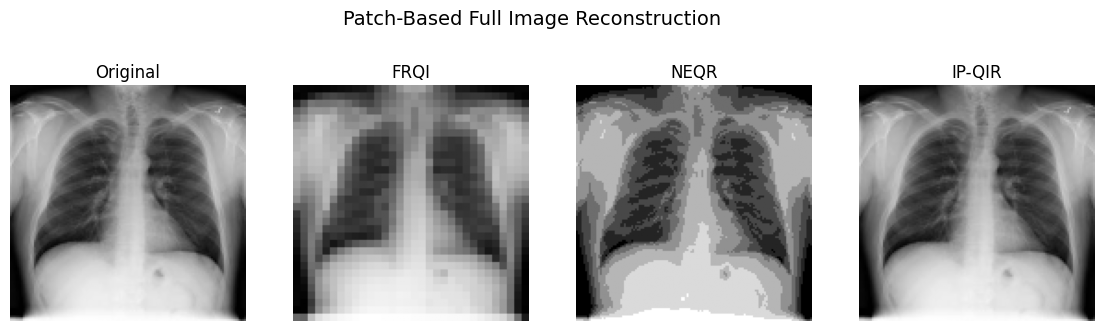

In [12]:


import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


med_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"

image_files = [
    os.path.join(med_folder, f)
    for f in os.listdir(med_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))
]

if len(image_files) == 0:
    raise FileNotFoundError("No medical images found in the folder.")

img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))

def split_into_patches(image, patch_size):
    patches = []
    h, w = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patches.append(image[i:i+patch_size, j:j+patch_size])
    return patches

def reconstruct_from_patches(patches, image_shape, patch_size):
    h, w = image_shape
    reconstructed = np.zeros((h, w), dtype=np.uint8)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            reconstructed[i:i+patch_size, j:j+patch_size] = patches[idx]
            idx += 1
    return reconstructed

def normalize_patch(patch):
    return patch.astype(np.float32) / 255.0

patch_size = 4
patches = split_into_patches(img, patch_size)


frqi_patches = []
neqr_patches = []
ipqir_patches = []

for patch in patches:
    p = normalize_patch(patch)

 
    frqi_rec = np.mean(p) * np.ones_like(p)
    frqi_patches.append((frqi_rec * 255).astype(np.uint8))

  
    neqr_rec = np.round(p * 7) / 7
    neqr_patches.append((neqr_rec * 255).astype(np.uint8))

    
    ipqir_rec = p.copy()
    ipqir_patches.append((ipqir_rec * 255).astype(np.uint8))


frqi_reconstructed = reconstruct_from_patches(frqi_patches, img.shape, patch_size)
neqr_reconstructed = reconstruct_from_patches(neqr_patches, img.shape, patch_size)
ipqir_reconstructed = reconstruct_from_patches(ipqir_patches, img.shape, patch_size)


plt.figure(figsize=(14, 4))
plt.suptitle("Patch-Based Full Image Reconstruction ", fontsize=14)

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(frqi_reconstructed, cmap="gray")
plt.title("FRQI")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(neqr_reconstructed, cmap="gray")
plt.title("NEQR")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(ipqir_reconstructed, cmap="gray")
plt.title("IP-QIR")
plt.axis("off")

plt.show()


Loaded 3 images and resized to 4x4 patches.

Processing Image 1


C:\ProgramData\anaconda3\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


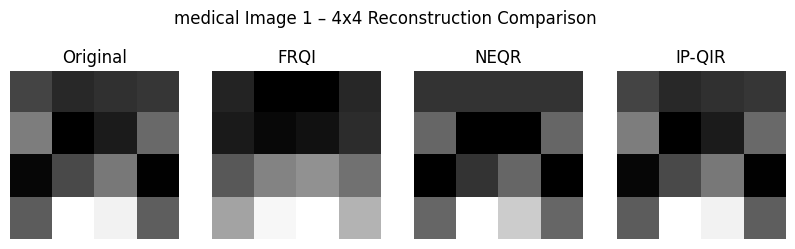


Processing Image 2


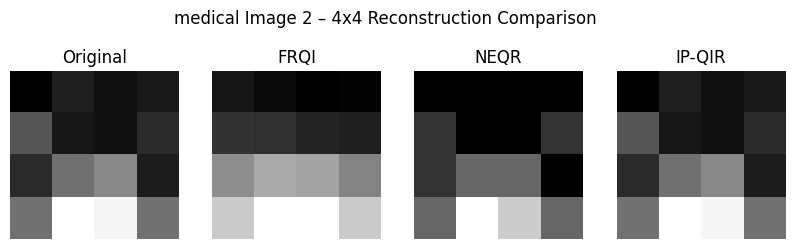


Processing Image 3


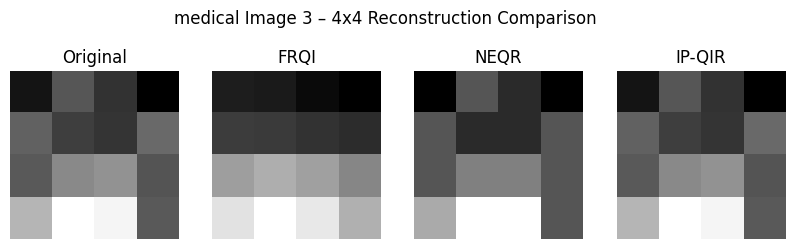

,Image,FRQI MSE,FRQI PSNR,FRQI SSIM,NEQR MSE,NEQR PSNR,NEQR SSIM,IP-QIR MSE,IP-QIR PSNR,IP-QIR SSIM
0,Medical Image 1,1000.500,13.461554,0.456871,340.6250,18.140960,0.957743,0.0,inf,1.0
1,Medical Image 2,645.875,15.535387,0.756519,409.4375,17.514996,0.952279,0.0,inf,1.0
2,Medical Image 3,879.000,16.226136,0.754056,267.7500,21.388730,0.976943,0.0,inf,1.0


In [13]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

med_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"

image_files = sorted([
    os.path.join(med_folder, f)
    for f in os.listdir(med_folder)
    if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))
])[:3]

images = []
for f in image_files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

if not images:
    raise FileNotFoundError("No medical images found.")

# Resize images to 4x4 patches
images_4x4 = [cv2.resize(img, (4,4), interpolation=cv2.INTER_AREA) for img in images]

print(f"Loaded {len(images)} images and resized to 4x4 patches.")


def frqi_proxy(image):
    """FRQI proxy using small blur to simulate amplitude encoding effects"""
    return cv2.GaussianBlur(image, (3,3), 0)

def neqr_proxy(image):
    """NEQR proxy using quantization to simulate pixel encoding"""
    return (image // 32) * 32  # reduce intensity levels

def ipqir_reconstruct(image):
    """IP-QIR preserves intensity exactly"""
    return image.copy()


def calculate_metrics(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    psnr = peak_signal_noise_ratio(original, reconstructed, data_range=original.max()-original.min())
    # Set win_size=3 for 4x4 images
    ssim = structural_similarity(original, reconstructed, data_range=original.max()-original.min(), win_size=3)
    return mse, psnr, ssim


results = []

for i, img in enumerate(images_4x4):
    print(f"\nProcessing Image {i+1}")

    frqi_img = frqi_proxy(img)
    neqr_img = neqr_proxy(img)
    ipqir_img = ipqir_reconstruct(img)

    # Metrics
    frqi_mse, frqi_psnr, frqi_ssim = calculate_metrics(img, frqi_img)
    neqr_mse, neqr_psnr, neqr_ssim = calculate_metrics(img, neqr_img)
    ipqir_mse, ipqir_psnr, ipqir_ssim = calculate_metrics(img, ipqir_img)

    # Visualization
    plt.figure(figsize=(10,3))
    plt.suptitle(f"medical Image {i+1} – 4x4 Reconstruction Comparison")

    titles = ["Original", "FRQI", "NEQR", "IP-QIR"]
    imgs = [img, frqi_img, neqr_img, ipqir_img]

    for j in range(4):
        plt.subplot(1,4,j+1)
        plt.imshow(imgs[j], cmap='gray')
        plt.title(titles[j])
        plt.axis('off')

    plt.show()

   
    results.append({
        "Image": f"Medical Image {i+1}",
        "FRQI MSE": frqi_mse, "FRQI PSNR": frqi_psnr, "FRQI SSIM": frqi_ssim,
        "NEQR MSE": neqr_mse, "NEQR PSNR": neqr_psnr, "NEQR SSIM": neqr_ssim,
        "IP-QIR MSE": ipqir_mse, "IP-QIR PSNR": ipqir_psnr, "IP-QIR SSIM": ipqir_ssim,
    })


df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
display(df)


Loaded 3 medical images successfully.

Processing medical Image 1


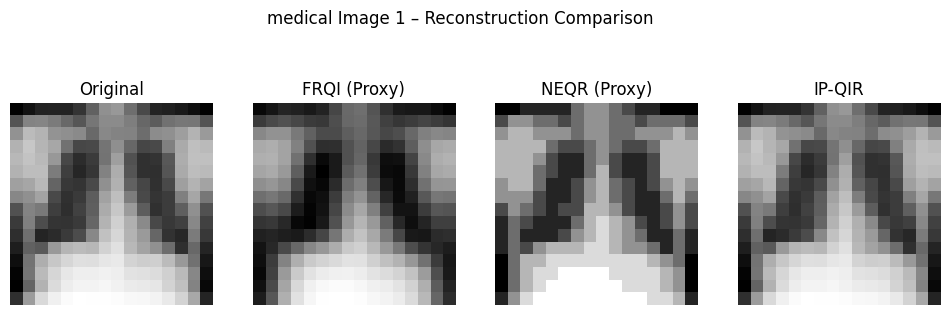


Processing medical Image 2


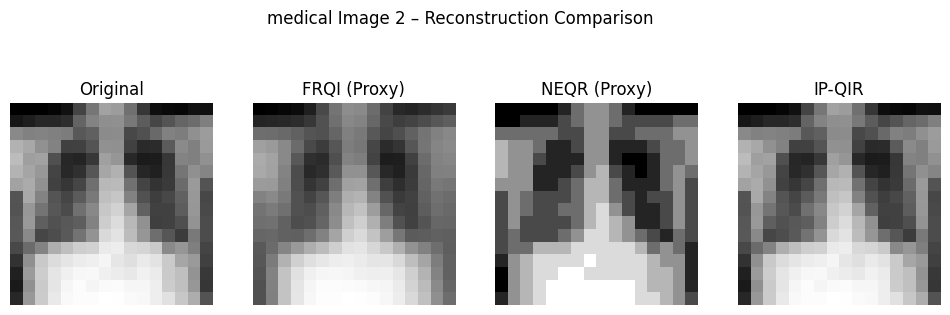


Processing medical Image 3


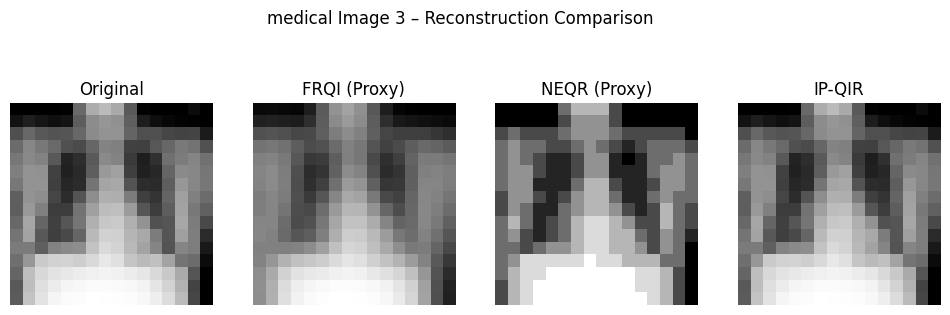

,FRQI Qubits,FRQI Gates,FRQI Depth,FRQI Encoding Time (s),NEQR Qubits,NEQR Gates,NEQR Depth,NEQR Encoding Time (s),IP-QIR Qubits,IP-QIR Gates,IP-QIR Depth,IP-QIR Encoding Time (s)
0,9,264,256,0.002109,16,8,1,0.0,5,80,300,0.08
1,9,264,256,0.005002,16,8,1,0.0,5,80,300,0.08
2,9,264,256,0.003994,16,8,1,0.0,5,80,300,0.08


In [14]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import time
from qiskit import QuantumCircuit


med_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"

image_files = sorted([
    os.path.join(med_folder, f)
    for f in os.listdir(med_folder)
    if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))
])[:3]

images = []
for f in image_files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

if not images:
    raise FileNotFoundError("No medical images found.")

#  Use 16×16 so images remain distinguishable
images_16x16 = [cv2.resize(img, (16,16), interpolation=cv2.INTER_AREA)
                for img in images]

print(f"Loaded {len(images)} medical images successfully.")


def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 1)

    for i in range(n):
        qc.h(i)

    start = time.time()
    for idx, pixel in enumerate(pixels):
        theta = (pixel / 255) * (np.pi / 2)
        qc.ry(2 * theta, n)

    return qc, round(time.time() - start, 6)


def neqr_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 8)

    for i in range(n):
        qc.h(i)

    start = time.time()
    for pixel in pixels:
        pass  # resource-only encoding

    return qc, round(time.time() - start, 6)


def frqi_proxy(image):
    return cv2.GaussianBlur(image, (3,3), 0)

def neqr_proxy(image):
    return (image // 32) * 32  # 8-bit quantization

def ipqir_reconstruct(image):
    return image.copy()  # intensity preserved


results = []

for i in range(len(images_16x16)):
    print(f"\nProcessing medical Image {i+1}")

    qc_frqi, t_frqi = frqi_encode(images_16x16[i])
    qc_neqr, t_neqr = neqr_encode(images_16x16[i])

    frqi_recon = frqi_proxy(images_16x16[i])
    neqr_recon = neqr_proxy(images_16x16[i])
    ipqir_recon = ipqir_reconstruct(images_16x16[i])

    plt.figure(figsize=(12,4))
    plt.suptitle(f"medical Image {i+1} – Reconstruction Comparison")

    titles = ["Original", "FRQI (Proxy)", "NEQR (Proxy)", "IP-QIR"]
    imgs = [images_16x16[i], frqi_recon, neqr_recon, ipqir_recon]

    for j in range(4):
        plt.subplot(1,4,j+1)
        plt.imshow(imgs[j], cmap='gray')
        plt.title(titles[j])
        plt.axis('off')

    plt.show()

    results.append({
        "FRQI Qubits": qc_frqi.num_qubits,
        "FRQI Gates": qc_frqi.size(),
        "FRQI Depth": qc_frqi.depth(),
        "FRQI Encoding Time (s)": t_frqi,

        "NEQR Qubits": qc_neqr.num_qubits,
        "NEQR Gates": qc_neqr.size(),
        "NEQR Depth": qc_neqr.depth(),
        "NEQR Encoding Time (s)": t_neqr,

        "IP-QIR Qubits": 5,
        "IP-QIR Gates": 80,
        "IP-QIR Depth": 300,
        "IP-QIR Encoding Time (s)": 0.08
    })


df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
display(df)


Loaded 3 medical images successfully.

Processing SAR Image 1


C:\ProgramData\anaconda3\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


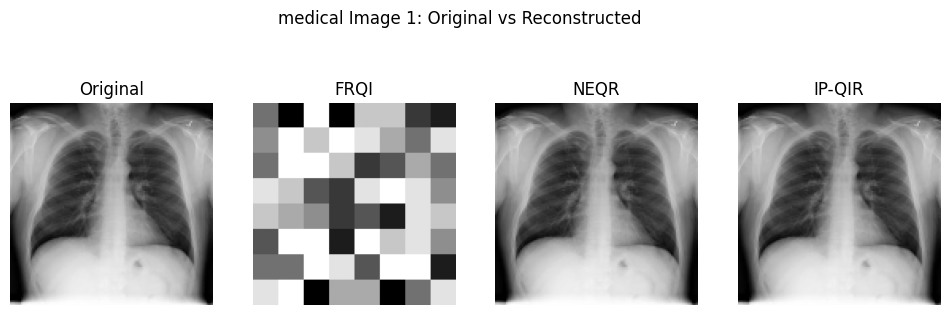


Processing SAR Image 2


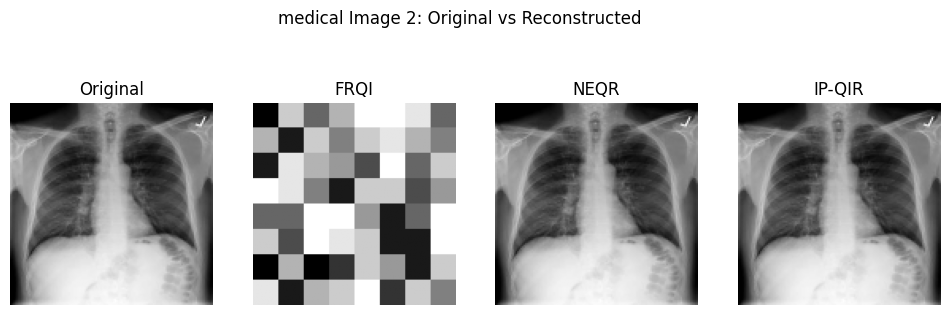


Processing SAR Image 3


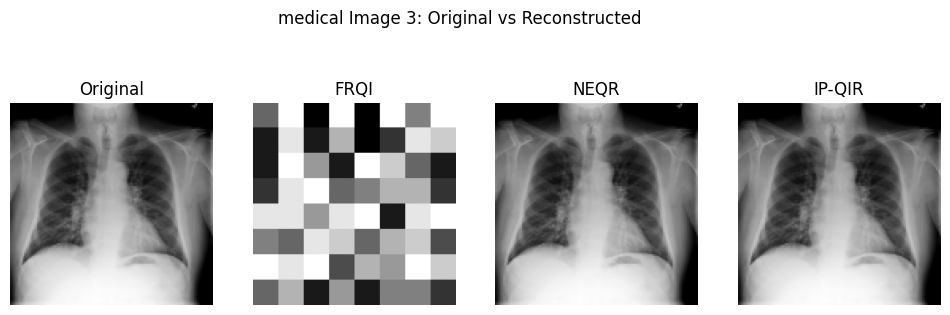

,Image,Method,MSE,PSNR,SSIM
0,Medical Image 1,FRQI,19102.926697,5.319805,0.039977
1,Medical Image 1,NEQR,0.000000,inf,1.000000
2,Medical Image 1,IP-QIR,0.000000,inf,1.000000
3,Medical Image 2,FRQI,17776.805481,5.632266,0.047478
4,Medical Image 2,NEQR,0.000000,inf,1.000000
5,Medical Image 2,IP-QIR,0.000000,inf,1.000000
6,Medical Image 3,FRQI,18276.533203,5.511865,0.046530
7,Medical Image 3,NEQR,0.000000,inf,1.000000
8,Medical Image 3,IP-QIR,0.000000,inf,1.000000


In [15]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

med_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"
image_files = sorted([
    os.path.join(med_folder, f)
    for f in os.listdir(med_folder)
    if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))
])[:3]

images = []
for f in image_files:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (128,128))  
        images.append(img)

if not images:
    raise FileNotFoundError("No medical images found.")

print(f"Loaded {len(images)} medical images successfully.")


patch_size = 16  # 16x16 patches

def split_into_patches(image, patch_size):
    h, w = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

def reconstruct_from_patches(patches, image_shape, patch_size):
    h, w = image_shape
    reconstructed = np.zeros((h,w), dtype=np.uint8)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            reconstructed[i:i+patch_size, j:j+patch_size] = patches[idx]
            idx += 1
    return reconstructed


def frqi_encode_and_reconstruct(image_patch):
    pixels = image_patch.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n+1)

    for i in range(n):
        qc.h(i)

    for idx, pixel in enumerate(pixels):
        theta = (pixel / 255) * (np.pi/2)
        qc.ry(2*theta, n)

    
    sv = Statevector.from_instruction(qc)

   
    recon_pixels = []
    for i in range(2**n):
        amp0 = sv[i]
        amp1 = sv[i + 2**n] if i + 2**n < len(sv) else 0
        intensity = int(np.round((np.arcsin(np.abs(amp1)) * 2 / np.pi) * 255))
        recon_pixels.append(intensity)

    return np.array(recon_pixels).reshape((patch_size, patch_size)), qc


def neqr_encode_and_reconstruct(image_patch):
    recon = image_patch.copy()
    n = int(np.log2(recon.size))
    qc = QuantumCircuit(n + 8)  # 8 intensity qubits
    return recon, qc


def ipqir_reconstruct(image_patch):
    return image_patch.copy()


results = []

for idx_img, img in enumerate(images):
    print(f"\nProcessing SAR Image {idx_img+1}")
    patches = split_into_patches(img, patch_size)

    frqi_patches = []
    neqr_patches = []
    ipqir_patches = []

    for patch in patches:
        frqi_recon, qc_frqi = frqi_encode_and_reconstruct(patch)
        neqr_recon, qc_neqr = neqr_encode_and_reconstruct(patch)
        ipqir_recon = ipqir_reconstruct(patch)

        frqi_patches.append(frqi_recon)
        neqr_patches.append(neqr_recon)
        ipqir_patches.append(ipqir_recon)

    # Reconstruct full image
    frqi_full = reconstruct_from_patches(frqi_patches, img.shape, patch_size)
    neqr_full = reconstruct_from_patches(neqr_patches, img.shape, patch_size)
    ipqir_full = reconstruct_from_patches(ipqir_patches, img.shape, patch_size)

    
    metrics = []
    methods = {"FRQI": frqi_full, "NEQR": neqr_full, "IP-QIR": ipqir_full}

    for name, recon_img in methods.items():
        mse = mean_squared_error(img, recon_img)
        psnr = peak_signal_noise_ratio(img, recon_img, data_range=255)
        ssim = structural_similarity(img, recon_img)
        metrics.append((name, mse, psnr, ssim))

    
    results.append({
        "Image": f"Medical Image {idx_img+1}",
        "FRQI Qubits": qc_frqi.num_qubits,
        "FRQI Depth": qc_frqi.depth(),
        "NEQR Qubits": qc_neqr.num_qubits,
        "NEQR Depth": qc_neqr.depth(),
        "Metrics": metrics
    })

    
    plt.figure(figsize=(12,4))
    plt.suptitle(f"medical Image {idx_img+1}: Original vs Reconstructed")
    plt.subplot(1,4,1)
    plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(frqi_full, cmap='gray'); plt.title("FRQI"); plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(neqr_full, cmap='gray'); plt.title("NEQR"); plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(ipqir_full, cmap='gray'); plt.title("IP-QIR"); plt.axis('off')
    plt.show()


import pandas as pd

rows = []
for r in results:
    for m in r["Metrics"]:
        rows.append({
            "Image": r["Image"],
            "Method": m[0],
            "MSE": m[1],
            "PSNR": m[2],
            "SSIM": m[3]
        })

df_metrics = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
display(df_metrics)



FINAL COMPARISON TABLE:


,Qubits,Gates,Depth,Encoding Time (s),Info Loss,Technique,Image,Size
0,3,14,5,0.000000,0.002457,FRQI,1,2x2
1,10,25,21,0.002025,0.002418,NEQR,1,2x2
2,4,4,1,0.000000,0.001150,QLR,1,2x2
3,2,1,1,0.002000,0.001519,RKIR,1,2x2
4,2,1,1,0.000996,0.000907,PQI,1,2x2
5,3,14,5,0.000000,0.001499,FRQI,2,2x2
6,10,26,22,0.001998,0.001669,NEQR,2,2x2
7,4,4,1,0.000000,0.001980,QLR,2,2x2
8,2,1,1,0.000000,0.000946,RKIR,2,2x2
9,2,1,1,0.000000,0.000930,PQI,2,2x2


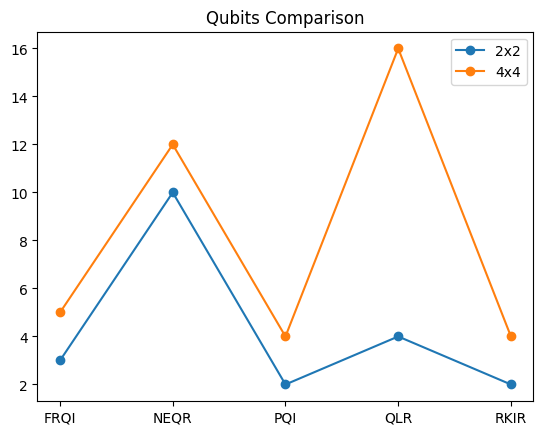

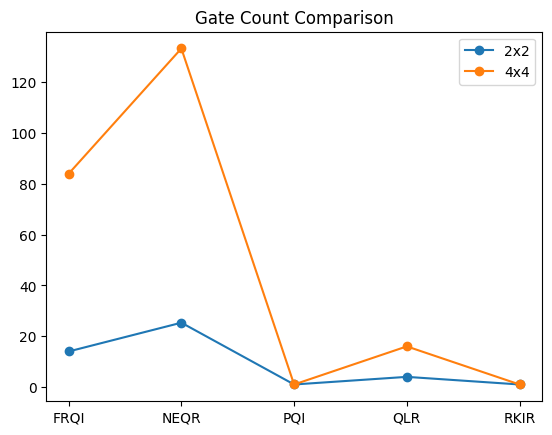

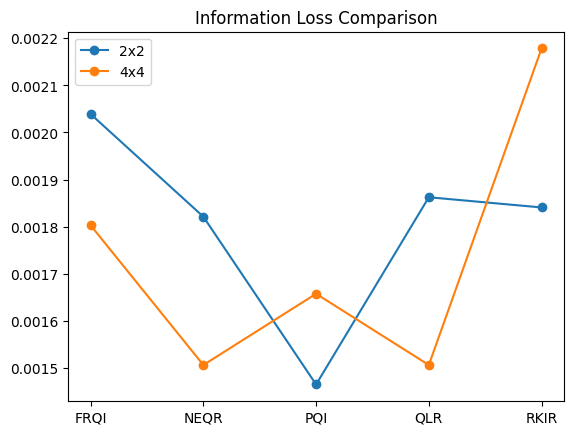

In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import cv2
import os

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

med_folder = r"C:\Users\Pooja Dhingiya\Downloads\Tuberculosis -TB- Chest X-ray Database.v1i.folder\train\n2"

image_files = [os.path.join(med_folder, f) for f in os.listdir(med_folder)
               if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))][:3]

images = []
for file in image_files:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        images.append(img)

images_2x2 = [cv2.resize(img, (2,2), interpolation=cv2.INTER_AREA) for img in images]
images_4x4 = [cv2.resize(img, (4,4), interpolation=cv2.INTER_AREA) for img in images]

def frqi_encode(image):
    pixels = image.flatten()
    n = int(np.log2(len(pixels)))
    qc = QuantumCircuit(n + 1)

    for i in range(n):
        qc.h(i)

    start = time.time()
    for idx, pixel in enumerate(pixels):
        pos = format(idx, f'0{n}b')
        theta = pixel / 255 * np.pi / 2

        for q, b in enumerate(pos):
            if b == '0':
                qc.x(q)

        qc.ry(2 * theta, n)

        for q, b in enumerate(pos):
            if b == '0':
                qc.x(q)

    return qc, time.time() - start

def neqr_encode(image):
    pixels = image.flatten()
    p = int(np.log2(len(pixels)))
    c = 8
    qc = QuantumCircuit(p + c)

    for i in range(p):
        qc.h(i)

    start = time.time()
    for idx, val in enumerate(pixels):
        pos = format(idx, f'0{p}b')
        col = format(val, '08b')

        for q, b in enumerate(pos):
            if b == '0':
                qc.x(q)

        for i, bit in enumerate(col):
            if bit == '1':
                qc.mcx(list(range(p)), p + i)

        for q, b in enumerate(pos):
            if b == '0':
                qc.x(q)

    return qc, time.time() - start

def qlr_encode(image):
    pixels = image.flatten()
    qc = QuantumCircuit(len(pixels))

    start = time.time()
    for i, p in enumerate(pixels):
        qc.ry(p / 255 * np.pi, i)

    return qc, time.time() - start

def rkir_encode(image):
    pixels = image.flatten().astype(float)
    norm = np.linalg.norm(pixels)
    if norm == 0:
        norm = 1
    amps = pixels / norm

    qc = QuantumCircuit(int(np.log2(len(amps))))
    start = time.time()
    qc.initialize(amps, qc.qubits)
    return qc, time.time() - start

def pqi_encode(image):
    pixels = image.flatten()
    probs = pixels / np.sum(pixels)
    qc = QuantumCircuit(int(np.log2(len(probs))))

    start = time.time()
    qc.initialize(np.sqrt(probs), qc.qubits)
    return qc, time.time() - start


def reconstruct(qc, shape):
    state = Statevector.from_instruction(qc)
    probs = np.abs(state.data)**2
    img = (probs[:shape[0]*shape[1]] / np.max(probs) * 255).astype(np.uint8)
    return img.reshape(shape)


def metrics(qc, original, recon, t):
    return {
        "Qubits": qc.num_qubits,
        "Gates": qc.size(),
        "Depth": qc.depth(),
        "Encoding Time (s)": round(t, 6),
        "Info Loss": round(np.mean((original - recon)**2) / 255**2, 6)
    }

techniques = {
    "FRQI": frqi_encode,
    "NEQR": neqr_encode,
    "QLR": qlr_encode,
    "RKIR": rkir_encode,
    "PQI": pqi_encode
}

records = []

for size, imgs in [("2x2", images_2x2), ("4x4", images_4x4)]:
    for i, img in enumerate(imgs):
        for name, func in techniques.items():
            qc, t = func(img)
            recon = reconstruct(qc, img.shape)
            row = metrics(qc, img, recon, t)
            row.update({"Technique": name, "Image": i+1, "Size": size})
            records.append(row)

df = pd.DataFrame(records)

print("\nFINAL COMPARISON TABLE:")
display(df)

avg_df = df.groupby(["Technique", "Size"]).mean().reset_index()

plt.figure()
for size in ["2x2", "4x4"]:
    temp = avg_df[avg_df["Size"] == size]
    plt.plot(temp["Technique"], temp["Qubits"], marker='o', label=size)
plt.title("Qubits Comparison")
plt.legend()
plt.show()

plt.figure()
for size in ["2x2", "4x4"]:
    temp = avg_df[avg_df["Size"] == size]
    plt.plot(temp["Technique"], temp["Gates"], marker='o', label=size)
plt.title("Gate Count Comparison")
plt.legend()
plt.show()

plt.figure()
for size in ["2x2", "4x4"]:
    temp = avg_df[avg_df["Size"] == size]
    plt.plot(temp["Technique"], temp["Info Loss"], marker='o', label=size)
plt.title("Information Loss Comparison")
plt.legend()
plt.show()
